In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as utils
import torchvision.transforms.v2 as v2

from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from einops import rearrange, repeat

In [ ]:

#### General Parameters ####

IMAGE_SIZE = 256
PATCH_SIZE = 8
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

BERT_FREEZE_LAYERS = 6
MODEL_DIM = 768
LR_BERT = 1e-5
LR_VIT = 2e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

In [4]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        
        self.bert = AutoModel.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
        
        for name, param in self.bert.named_parameters():
            if 'encoder.layer' in name:
                layer_num = int(name.split('encoder.layer.')[1].split('.')[0])
                if layer_num < BERT_FREEZE_LAYERS:
                    param.requires_grad = False
    
    def tokenize(self, texts):
        encoded_text = self.tokenizer(texts, padding=True, truncation=True, 
                                      return_tensors="pt", max_length=128).to(DEVICE)

        return encoded_text
    
    def forward(self, encoded_text):
        outputs = self.bert(**encoded_text)
        
        return outputs.last_hidden_state

In [5]:
class VisionEncoder(nn.Module):
    def __init__(
        self,
        img_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        in_channels=1,
        embed_dim=MODEL_DIM,
        depths=[2, 2, 2, 2],
        num_heads=12,
    ):
        super(VisionEncoder, self).__init__()

        self.img_size = img_size
        self.channels = [embed_dim // 8, embed_dim // 4, embed_dim // 2, embed_dim]

        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(
                in_channels,
                embed_dim // 8,
                kernel_size=patch_size,
                stride=patch_size,
            ),
        )

        self.encoders = nn.ModuleList()
        self.upsamplers = nn.ModuleList()
        self.position_embedding = nn.ParameterList([
            nn.Parameter(torch.randn(1, NUM_PATCHES, d), requires_grad=True)
            for d in self.channels
        ])

        dim = embed_dim // 8
        for i, depth in enumerate(depths):
            self.encoders.append(
                nn.TransformerEncoder(
                    nn.TransformerEncoderLayer(
                        d_model=dim,
                        nhead=num_heads // (2 ** (3 - i)),
                        dim_feedforward=int(dim * 3.5),
                        batch_first=True,
                    ),
                    num_layers=depth,
                )
            )

            self.upsamplers.append(
                nn.Sequential(
                    nn.LayerNorm(dim), nn.Linear(in_features=dim, out_features=dim * 2)
                )
                if i < len(depths) - 1
                else nn.Identity()
            )

            dim *= 2

    def forward(self, X):
        X = self.patch_embed(X)  # [B, 96, 32, 32]

        features = []
        for i, (encoder, upsampler, position) in enumerate(
            zip(self.encoders, self.upsamplers, self.position_embedding)
        ):
            X_seq = rearrange(X, "b c h w -> b (h w) c")

            X_seq = encoder(X_seq + position)
            features.append(X_seq)

            Xnew = rearrange(
                X_seq, "b (h w) c -> b c h w", h=self.img_size, w=self.img_size
            )

            if i < len(self.upsamplers) - 1:
                X = upsampler[i](X + Xnew)  # [B, C*2, 32, 32]

        return features

In [6]:
class VisionDecoder(nn.Module):
    def __init__(
        self,
        img_size=IMAGE_SIZE,
        embed_dim=MODEL_DIM,
        num_heads=12,
        dropout=0.1,
        mlp_ratio=3.5,
        output_hidden=2048,
        output_dim=1024,
    ):
        super(VisionDecoder, self).__init__()

        self.img_size = img_size
        self.dropout = dropout
        self.channels = [embed_dim // 8, embed_dim // 4, embed_dim // 2, embed_dim]

        self.cross_attention = nn.ModuleList()
        self.pre_mlp_norm = nn.ModuleList()
        self.post_mlp_norm = nn.ModuleList()
        self.mlp_blocks = nn.ModuleList()
        self.upsamplers = nn.ModuleList()

        for i, dim in enumerate(self.channels):
            self.cross_attention.append(
                nn.MultiheadAttention(
                    embed_dim=dim,
                    num_heads=num_heads // (2 ** (3 - i)),
                    dropout=dropout,
                    kdim=embed_dim,
                    vdim=embed_dim,
                    batch_first=True,
                )
            )

            self.pre_mlp_norm.append(nn.LayerNorm(dim))
            self.post_mlp_norm.append(nn.LayerNorm(dim))
            self.mlp_blocks.append(
                nn.Sequential(
                    nn.Linear(in_features=dim, out_features=int(mlp_ratio * dim)),
                    nn.ReLU(),
                    nn.Linear(in_features=int(mlp_ratio * dim), out_features=dim)
                )
            )

            self.upsamplers.append(
                nn.Sequential(
                    nn.Linear(in_features=dim, out_features=dim * 2), nn.LayerNorm(dim)
                )
                if i < len(self.channels) - 1
                else nn.LayerNorm(dim)
            )

        self.final_mlp = nn.Sequential(
            *[
                nn.Linear(in_features=embed_dim, out_features=output_hidden),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=output_hidden, out_features=output_hidden),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=output_hidden, out_features=output_hidden),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=output_hidden, out_features=output_dim),
                nn.ReLU(),
            ]
        )

    def forward(self, img_features, T):
        features = []
        for i, (attn, pre_norm, post_norm, mlp, upsampler) in enumerate(
            zip(
                self.cross_attention,
                self.pre_mlp_norm,
                self.post_mlp_norm,
                self.mlp_blocks,
                self.upsamplers,
            )
        ):
            src = img_features[i]
            if i > 0:
                src += features[i - 1]

            X = attn(query=src, key=T, value=T)

            X = F.dropout(X, p=self.dropout, training=self.training)
            X = pre_norm(X + src)

            Xff = mlp(X)

            Xff = F.dropout(Xff, p=self.dropout, training=self.training)
            X = post_norm(X + Xff)

            X = upsampler(X)
            features.append(X)

        return self.final_mlp(features[-1])

In [7]:
class VisionOutputHead(nn.Module):
    def __init__(
        self,
        in_dim=1024,
    ):
        super(VisionOutputHead, self).__init__()

        self.binary_output = nn.Sequential(
            *[
                nn.LayerNorm(in_dim),
                nn.Linear(in_features=in_dim, out_features=in_dim // 4),
                nn.GELU(),
                nn.Linear(in_features=in_dim // 4, out_features=1),
                nn.Sigmoid(),
            ]
        )

        self.count_output = nn.Sequential(
            *[
                nn.LayerNorm(in_dim),
                nn.Linear(in_features=in_dim, out_features=in_dim // 4),
                nn.GELU(),
                nn.Linear(in_features=in_dim // 4, out_features=1),
            ]
        )

    def forward(self, X):
        binary = self.binary_output(X)
        count = self.count_output(X)

        return binary, count

In [8]:
class MultiModalViT(nn.Module):
    def __init__(
        self,
        img_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        in_channels=1,
        embed_dim=MODEL_DIM,
        encoder_depths=[2, 2, 2, 2],
        output_dim=1024,
    ):
        super(MultiModalViT, self).__init__()
        
        self.text_encoder = TextEncoder()

        self.encoder = VisionEncoder(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim,
            depths=encoder_depths,
        )

        self.decoder = VisionDecoder(
            img_size=img_size, embed_dim=embed_dim, output_dim=output_dim
        )

        self.output = VisionOutputHead(in_dim=output_dim)
    
    def forward(self, imgs, texts):
        text_embeddings = [self.text_encoder(text) for text in texts]
        features = self.encoder(imgs)
        
        decoded_out = self.decoder(features, text_embeddings)
        binary, count = self.output(decoded_out)
        
        return binary, count

In [9]:
import os
import csv
import glob
import random

from data import (
    Datapoint,
    SegmentationDataset,
    generate_labels,
    normalize_images,
    enhance_contrast,
    enhance_edges,
)
from typing import List


label_map = {}
with open("data/combined_label_index.csv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        label_map[int(row["id"]) - 1] = row["name"].replace("_", " ")

matches = glob.glob('data/**/*.npy', recursive=True)
data: List[Datapoint] = []
view_map = {
    "AP": "anteroposterior",
    "PA": "posteroanterior",
    "LLAT": "left lateral",
    "RLAT": "right lateral",
}

mask_transforms = v2.Compose(
    [
        v2.Resize(
            size=(256, 256), interpolation=v2.InterpolationMode.BICUBIC, antialias=True
        ),
    ]
)

transforms = v2.Compose(
    [
        v2.Lambda(lambda x: (rearrange(x, "c h w -> h w c") * 255).astype(np.uint8)),
        v2.Lambda(enhance_contrast),
        v2.Lambda(enhance_edges),
        v2.Lambda(
            lambda x: (
                rearrange(x, "h w c -> c h w", h=IMAGE_SIZE, w=IMAGE_SIZE) / 255
            ).astype(np.float32)
        ),
    ]
)

for i, file_path in enumerate(matches):
    print(file_path)
    
    images = rearrange(np.load(file_path), "c b h w -> b c h w")
    images = mask_transforms.forward(torch.tensor(images)).numpy()
    images = normalize_images(images)

    base = np.sum(images, axis=0)
    base = normalize_images(base)
    base = transforms.forward(base)
    images = images[1:, ...]

    view = view_map[os.path.basename(file_path).rstrip("_labels.npy")]
    for i in range(images.shape[0]):
        structure = label_map[i]
        mask: np.ndarray = images[i]
        
        p1 = np.percentile(mask.flatten(), [5])
        if np.count_nonzero(mask > p1) == 0 and random.random() < 0.8:
            continue # reduce number of empty examples
            
        binary, count = generate_labels(mask=(mask > p1), patch_size=PATCH_SIZE)
        data.append(
            Datapoint(
                base_img=base,
                gt_mask=mask,
                label_binary=binary,
                label_count=count,
                structure=structure,
                view=view,
            )
        )

data\AP_labels.npy
data\LLAT_labels.npy
data\PA_labels.npy
data\RLAT_labels.npy
data\bulk\s0011\AP_labels.npy
data\bulk\s0011\LLAT_labels.npy
data\bulk\s0011\PA_labels.npy
data\bulk\s0011\RLAT_labels.npy
data\bulk\s0250\AP_labels.npy
data\bulk\s0250\LLAT_labels.npy
data\bulk\s0250\PA_labels.npy
data\bulk\s0250\RLAT_labels.npy
data\bulk\s0344\AP_labels.npy
data\bulk\s0344\LLAT_labels.npy
data\bulk\s0344\PA_labels.npy
data\bulk\s0344\RLAT_labels.npy
data\bulk\s0461\AP_labels.npy
data\bulk\s0461\LLAT_labels.npy
data\bulk\s0461\PA_labels.npy
data\bulk\s0461\RLAT_labels.npy
data\bulk\s0477\AP_labels.npy
data\bulk\s0477\LLAT_labels.npy
data\bulk\s0477\PA_labels.npy
data\bulk\s0477\RLAT_labels.npy
data\bulk\s0513\AP_labels.npy
data\bulk\s0513\LLAT_labels.npy
data\bulk\s0513\PA_labels.npy
data\bulk\s0513\RLAT_labels.npy
data\bulk\s0519\AP_labels.npy
data\bulk\s0519\LLAT_labels.npy
data\bulk\s0519\PA_labels.npy
data\bulk\s0519\RLAT_labels.npy
data\bulk\s0629\AP_labels.npy
data\bulk\s0629\LLAT_l

segmentation mask of hip left of an anteroposterior view xray
Empty Examples: 2454; Nonempty Examples: 13752


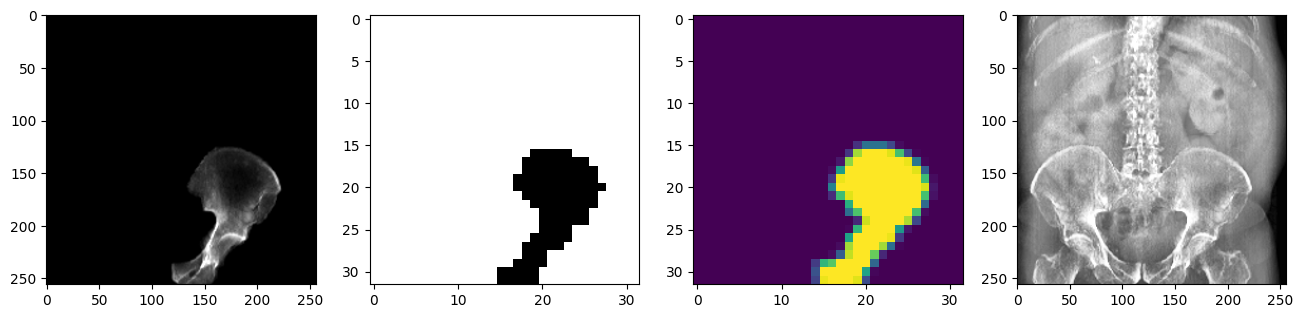

In [14]:
import matplotlib.pyplot as plt

dataset = SegmentationDataset(data)
prompt, base, binary, count, mask = dataset[700]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 16))
axs[0].imshow(rearrange(mask.numpy(), 'c h w -> h w c'), cmap='gray')
axs[1].imshow(binary.numpy(), cmap='binary', vmin=0, vmax=1)
axs[2].imshow(count.numpy())
axs[3].imshow(rearrange(base.numpy(), 'c h w -> h w c'), cmap='gray')

print(dataset.sentence_from_tensor(prompt))

empty_examples = 0
for (prompt, base, binary, count, mask) in dataset:
    if np.count_nonzero(binary.numpy()) == 0:
        empty_examples += 1

print(f'Empty Examples: {empty_examples}; Nonempty Examples: {len(dataset) - empty_examples}')

In [15]:
def get_lr(step, warmup_steps):
    if step < warmup_steps:
        return step / warmup_steps

    return 1.0


def training(model, dataset: SegmentationDataset, epochs=20, warmup_steps=100):
    model.to(DEVICE)

    text_encoder_params = {
        "params": [
            p for _, p in model.text_encoder.named_parameters() if p.requires_grad
        ]
    }
    other_params = {
        "params": [
            p
            for _, p in model.named_parameters()
            if p.requires_grad
            and not any(param is p for param in model.text_encoder.parameters())
        ]
    }

    train_set, val_set = torch.utils.data.random_split(range(30), [0.95, 0.05])
    train_loader = DataLoader(
        dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True
    )
    val_loader = DataLoader(
        dataset=val_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True
    )

    optimizer = optim.AdamW(
        [
            {**text_encoder_params, "lr": LR_BERT},
            {**other_params, "lr": LR_VIT},
        ]
    )
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(step, warmup_steps),
    )

    train_losses, val_losses = [], []
    for i in range(epochs):
        model.train()
        train_loss = 0.0

        for j, (prompt, base, binary_label, count_label, _) in enumerate(train_loader):
            texts = []
            for z in range(BATCH_SIZE):
                texts.append(dataset.sentence_from_tensor(prompt[z]))

            base = base.to(DEVICE)
            binary_label = binary_label.flatten(start_dim=1).to(DEVICE)
            count_label = count_label.flatten(start_dim=1).to(DEVICE)

            #############################

            binary, count = model(base, texts)
            bce_loss = F.binary_cross_entropy_with_logits(binary, binary_label)
            mse_loss = F.mse_loss(count, count_label)
            
            loss = bce_loss + mse_loss
            train_loss += loss.item()
            if j % 10:
                print(
                    f"Epoch {i}; Batch {j} : bce={bce_loss.item():.4f}, mse={mse_loss.item():.4f}, total={loss.item():.4f}"
                )

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            scheduler.step()
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for j, (prompt, base, binary_label, count_label, _) in enumerate(val_loader):
                texts = []
                for z in range(BATCH_SIZE):
                    texts.append(dataset.sentence_from_tensor(prompt[z]))

                base = base.to(DEVICE)
                binary_label = binary_label.flatten(start_dim=1).to(DEVICE)
                count_label = count_label.flatten(start_dim=1).to(DEVICE)

                #############################
                
                binary, count = model(base, texts)
                bce_loss = F.binary_cross_entropy_with_logits(binary, binary_label)
                mse_loss = F.mse_loss(count, count_label)
                
                loss = bce_loss + mse_loss
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        print(f"Epoch {i}; : training loss={train_loss:.4f}, validation loss={val_loss:.4f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [16]:
model = MultiModalViT(
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=1,
    embed_dim=MODEL_DIM,
    encoder_depths=[2, 2, 4, 6],
    output_dim=1024
)

print(f"Total Model Parameters: ~{sum(p.numel() for p in model.parameters()) / 1e6:.2f}mil")

e:\anaconda3\envs\cv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Total Model Parameters: ~180.13mil


In [ ]:
train_losses, val_losses = training(
    model=model, dataset=dataset, epochs=10, warmup_steps=100
)

fig, axs = plt.subplots(1, 2)

axs[0].plot(train_losses)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Training Loss")

axs[0].plot(val_losses)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Validation Loss")

fig.show(warn=False)

In [ ]:
with torch.no_grad():
    (prompt, base, binary_label, count_label, _) = dataset[
        random.randrange(0, len(dataset), step=1)
    ]

    texts = []
    for z in range(BATCH_SIZE):
        texts.append(dataset.sentence_from_tensor(prompt[z]))

    base = base.unsqueeze(0).to(DEVICE)
    binary_label = binary_label.flatten(start_dim=1).unsqueeze(0).to(DEVICE)
    count_label = count_label.flatten(start_dim=1).unsqueeze(0).to(DEVICE)

    #############################

    binary, count = model(base, texts)
    bce_loss = F.binary_cross_entropy_with_logits(binary, binary_label)
    mse_loss = F.mse_loss(count, count_label)

    loss = bce_loss + mse_loss
    print(f"Loss: {loss:.4f}")

    binary = F.sigmoid(binary).reshape(NUM_PATCHES, NUM_PATCHES)
    count = count.reshape(NUM_PATCHES, NUM_PATCHES)


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(16, 16))
axs[0].imshow(rearrange(base.cpu().detach().numpy(), "c h w -> h w c"), cmap="gray")
axs[1].imshow(
    binary_label.cpu().detach().numpy(),
    cmap="binary",
    vmin=0,
    vmax=1,
)
axs[2].imshow(count_label.cpu().detach().numpy())
axs[3].imshow(
    binary.cpu().detach().numpy(),
    cmap="binary",
    vmin=0,
    vmax=1,
)
axs[4].imshow(count.cpu().detach().numpy())

print(f"Prompt: {texts[0]}")